<a href="https://colab.research.google.com/github/jinnyjinny/DogFaceClassification/blob/master/Final_Sigol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warning
- Set GPU mode (not to activate with CPU)

# Dependency

In [ ]:
!pip install face_recognition

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import csv
import dlib, cv2
import math
from imutils import face_utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
np.seterr(over='ignore')
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import keras 
from keras.models import *
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.utils import np_utils 
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

In [ ]:
def sigol(input, label, model, detector, predictor):
    
    data = []
    ratio = []
    ##### Breed Predict #####
    breed_list = os.listdir(label)
    num_classes = len(breed_list)
    # print("{} breeds".format(num_classes))

    n_total_images = 0
    for breed in breed_list:
        n_total_images += len(os.listdir(label + "/{}".format(breed)))
    # print("{} images".format(n_total_images))

    label_maps = {}
    label_maps_rev = {}
    for i, v in enumerate(breed_list):
        label_maps.update({v: i})
        label_maps_rev.update({i : v})       

    ##### Load Image #####
    img = cv2.imread(input)
    breed_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ##### Predict image #####
    breed_img = imread(input)
    filename = os.path.splitext(os.path.basename(input))[0]
    breed_img = preprocess_input(breed_img)
    probs = model.predict(np.expand_dims(breed_img, axis=0))

    for idx in probs.argsort()[0][::-1][:1]:
        breed = label_maps_rev[idx].split("-")[-1]
  
    
    ##### Load Model #####
    detector = dlib.cnn_face_detection_model_v1(detector)
    predictor = dlib.shape_predictor(predictor)

    ##### Detect Face #####
    try:
      dets = detector(img, upsample_num_times=2)
    except RuntimeWarning as e:
      pass
    img_result = img.copy()

    for i, d in enumerate(dets):
        x1, y1 = d.rect.left(), d.rect.top()
        x2, y2 = d.rect.right(), d.rect.bottom()
        cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)

    ##### Detect Landmarks #####
    for i, d in enumerate(dets):
        shape = predictor(img, d.rect) # detect in range of d.rect 
        shape = face_utils.shape_to_np(shape)
        shape = shape.reshape(-1) # x0 y0 x1 y1 x2 y2 x3 y3 x4 y4 x5 y5
        ##### Landmarks Ratio #####
        x3 = int(shape[6])
        y3 = int(shape[7])
        x5 = int(shape[10])
        y5 = int(shape[11])
        x2 = int(shape[4])
        y2 = int(shape[5])
        area = abs ( (x5 - x3) * (y2 - y3) - (y5 - y3) * (x2 - x3) )
        AB = ( (x5 - x2) ** 2 + (y5 - y2) ** 2 ) ** 0.5
        ratio =  (area / AB) * 0.01
        ratio = round(ratio, 3)
      
    ##### RGB Pixel #####
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    k = 5
    clt = KMeans(n_clusters = k)
    clt.fit(img)
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()

    dictionary = {}   
    for (percent, color) in zip(hist, clt.cluster_centers_):
          startX=0
          endX = startX + (percent * 300)
          block = endX - startX
          dictionary[block] = color.astype("uint8")
          startX = endX

    rgb_max = max(dictionary.keys())
    rgb_max = dictionary[rgb_max]
    r = rgb_max[0]
    g = rgb_max[1]
    b = rgb_max[2]

    R = round(r/(r+g+b), 3) 
    G = round(g/(r+g+b), 3) 
    B = round(b/(r+g+b), 3) 

    data = [filename, ratio, R, G, B, breed]
    # print(data)
    return data

In [ ]:
##### Load Image #####
label = label_path
model = load_model(saved_model_path)
detector = detector_path
predictor = predictor_path

folder_path = folder_path
folder_list = os.listdir(folder_path)
folder_list.sort()
print(len(folder_list))

data = []
df = pd.DataFrame(columns=['filename' ,'ratio', 'r', 'g', 'b', 'breed'])
for f in folder_list:
    file_path = folder_path + '/' + f
    input = file_path
    try:
      data = sigol(input, label, model, detector, predictor) # 여기서 df 한 행이 만들어짐 
      df = df.append(pd.Series(data, index=df.columns), ignore_index=True)
    except ValueError as e:
      pass    

172


In [ ]:
df.head()

,filename,ratio,r,g,b,breed
0,_201002_194735_464,0.421,0.901,0.944,0.958,American_Staffordshire_terrier
1,_201002_194829_828,0.506,1.057,1.943,1.657,whippet
2,_201002_204551_730,0.144,4.909,10.818,8.545,Maltese_dog
3,_201002_204850_868,0.415,0.685,0.697,0.693,Pembroke
4,_201002_204907_568,0.288,1.260,1.240,1.060,Eskimo_dog


-----------Test Image-------------


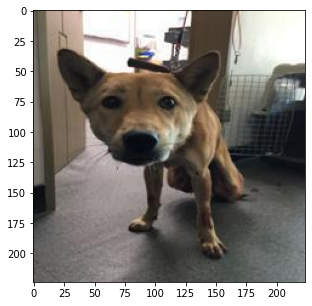

In [ ]:
# Test Image
input = input_image

print('-----------Test Image-------------')
search_data = sigol(input, label, model, detector, predictor)

img = cv2.imread(input)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img)


-----------Predict Image-------------
/content/drive/My Drive/Capstone Project/DY/FB_Dog/_201002_205533_656.jpg


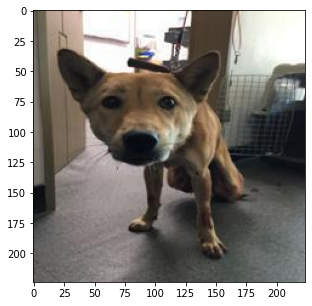

In [ ]:
print('-----------Predict Image-------------')
df = pd.read_csv(path)

d_list = []
r2 = search_data[2]
g2 = search_data[3] 
b2 = search_data[4]

for filename,r,g,b in zip(df['filename'], df['r'], df['g'], df['b']):
  r1 = round(r, 3) 
  g1 = round(g, 3)  
  b1 = round(b, 3)  
  d = round(math.sqrt((r1-r2)**2 + (g1-g2)**2 + (b1-b2)**2), 3)
  d_list.append(d)

d_min = min(d_list)
# print(pred)
index = d_list.index(d_min)
pred = df['filename'][index]
posted_img_path = path + pred + '.jpg'
print(posted_img_path)
img = cv2.imread(posted_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img)